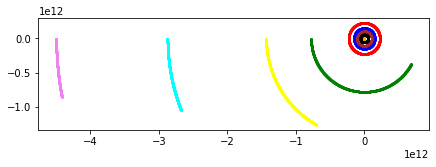

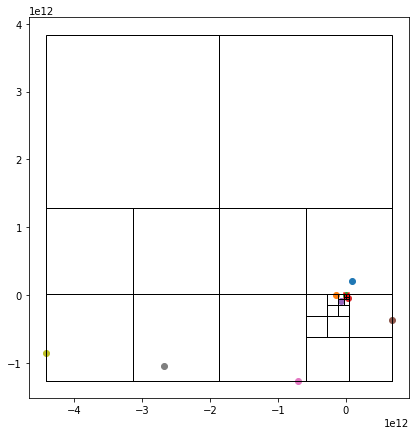

In [5]:
import numpy as np
import math

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches

import random

theta = 0.2
AU = 149.6e9     # in meters.
G = 6.67408e-11  #m^3 kg^-1 s^-2
figure1 = plt.figure(figsize=(7,7))
sim = figure1.add_subplot(111, aspect='equal')
figure2 = plt.figure(figsize=(7,7))
quadt = figure2.add_subplot(111, aspect='equal')

class Node:
    children = None
    mass = None
    center_of_mass = None
    bbox = None
    vx = vy = None

def quad_insert(root, x, y, m):
    if root.mass is None: 
        root.mass = m
        root.center_of_mass = [x,y]
        return
    elif root.children is None:
        root.children = [None,None,None,None]
        old_quadrant = quadrant_of_particle(root.bbox, root.center_of_mass[0], root.center_of_mass[1])
        if root.children[old_quadrant] is None:
            root.children[old_quadrant] = Node()
            root.children[old_quadrant].bbox = quadrant_bbox(root.bbox,old_quadrant)
        quad_insert(root.children[old_quadrant], root.center_of_mass[0], root.center_of_mass[1], root.mass)
        new_quadrant = quadrant_of_particle(root.bbox, x, y)
        if root.children[new_quadrant] is None:
            root.children[new_quadrant] = Node()
            root.children[new_quadrant].bbox = quadrant_bbox(root.bbox,new_quadrant)
        quad_insert(root.children[new_quadrant], x, y, m)
        root.center_of_mass[0] = (root.center_of_mass[0]*root.mass + x*m) / (root.mass + m)
        root.center_of_mass[1] = (root.center_of_mass[1]*root.mass + y*m) / (root.mass + m)
        root.mass = root.mass + m
    else:
        new_quadrant = quadrant_of_particle(root.bbox, x, y)
        if root.children[new_quadrant] is None:
            root.children[new_quadrant] = Node()
            root.children[new_quadrant].bbox = quadrant_bbox(root.bbox, new_quadrant)
        quad_insert(root.children[new_quadrant], x, y, m)
        root.center_of_mass[0] = (root.center_of_mass[0]*root.mass + x*m) / (root.mass + m)
        root.center_of_mass[1] = (root.center_of_mass[1]*root.mass + y*m) / (root.mass + m)
        root.mass = root.mass + m

def display(root):
    if root.mass is None:
        return
    if root.children is not None:
        x = (root.bbox[0] + root.bbox[1]) / 2
        y = (root.bbox[2] + root.bbox[3]) / 2
        width = x-root.bbox[0]
        plt_node(root.bbox[0], root.bbox[2], width)
        plt_node(root.bbox[0], y, width)
        plt_node(x, root.bbox[2], width)
        plt_node(x, y, width)
        for i in range(4):
            if root.children[i] is not None:
                display(root.children[i])
    else:
        quadt.scatter(root.center_of_mass[0], root.center_of_mass[1])

def integrate(particles):
    bodies = particles
    n = len(bodies)
    timestep = 24*3600
    years = 5 * 365 #total simulation time in Earth years
    for day in range(years):
        particles_force = {}
        root = Node()
        root.center_of_mass = []
        root.bbox = find_root_bbox(bodies)
        for i in range(n):
            quad_insert(root, bodies[i][3], bodies[i][4], bodies[i][2])
        for i in range(n):
            total_fx, total_fy = compute_force(root,bodies[i][3],bodies[i][4],bodies[i][2])
            particles_force[bodies[i][0]] = (total_fx, total_fy)
        for i in range(n):
            f_x, f_y = particles_force[bodies[i][0]]
            bodies[i][5] += f_x / bodies[i][2] * timestep
            bodies[i][6] += f_y / bodies[i][2] * timestep

            bodies[i][3] += bodies[i][5] * timestep
            bodies[i][4] += bodies[i][6] * timestep
            sim.scatter(bodies[i][3], bodies[i][4], c=bodies[i][1],s=1)
    display(root)
    quadt.scatter(root.center_of_mass[0], root.center_of_mass[1], c='red', marker='x')

def compute_force(root,x,y,m):
    if root.mass is None:
        return 0, 0
    if root.center_of_mass[0] == x and root.center_of_mass[1] == y and root.mass == m:
        return 0, 0
    d = root.bbox[1]-root.bbox[0]
    r = distance(x,y, root.center_of_mass[0], root.center_of_mass[1])
    if d/r < theta or root.children is None:
        return force(m, x, y, root.mass, root.center_of_mass[0], root.center_of_mass[1])
    else:
        f_x = 0.0
        f_y = 0.0
        for i in range(4):
            if root.children[i] is not None:
                f_x += compute_force(root.children[i],x,y,m)[0]
                f_y += compute_force(root.children[i],x,y,m)[1]
        return f_x, f_y

def force(m, x, y, mcm, x_cm, y_cm):
    d = distance(x, y, x_cm, y_cm)
    f = G*m*mcm/(d**2)
    dx = x_cm - x
    dy = y_cm - y
    angle = math.atan2(dy, dx)
    f_x = math.cos(angle) * f
    f_y = math.sin(angle) * f
    return f_x, f_y

def distance(x1, y1, x2, y2):
    return math.sqrt((x2-x1)**2+(y2-y1)**2)

def plt_node(x, y, width):
    quadt.add_patch(patches.Rectangle((x, y), width, width, fill = False))

def find_root_bbox(array):
    if len(array) == 0 or len(array) == 1:
        return None
    xmin, xmax, ymin, ymax = array[0][3], array[0][3], array[0][4], array[0][4]
    for i in range(len(array)):
        if array[i][3] > xmax:
            xmax = array[i][3]
        if array[i][3] < xmin:
            xmin = array[i][3]
        if array[i][4] > ymax:
            ymax = array[i][4]
        if array[i][4] < ymin:
            ymin = array[i][4]
    if xmax - xmin == ymax - ymin:
        return xmin, xmax, ymin, ymax
    elif xmax - xmin > ymax - ymin:
        return xmin, xmax, ymin, ymax+(xmax-xmin-ymax+ymin)
    else:
        return xmin, xmax+(ymax-ymin-xmax+xmin), ymin, ymax

def quadrant_of_particle(bbox, x, y):
    if y >= (bbox[3] + bbox[2])/2:
        if x <= (bbox[1] + bbox[0])/2:
            return 0
        else:
            return 1
    else:
        if x >= (bbox[1] + bbox[0])/2:
            return 2
        else:
            return 3

def quadrant_bbox(bbox,quadrant):
    x = (bbox[0] + bbox[1]) / 2
    y = (bbox[2] + bbox[3]) / 2
    #Quadrant 0: (xmin, x, y, ymax)
    if quadrant == 0:
        return bbox[0], x, y, bbox[3]
    #Quadrant 1: (x, xmax, y, ymax)
    elif quadrant == 1:
        return x, bbox[1], y, bbox[3]
    #Quadrant 2: (x, xmax, ymin, y)
    elif quadrant == 2:
        return x, bbox[1], bbox[2], y
    #Quadrant 3: (xmin, x, ymin, y)
    elif quadrant == 3:
        return bbox[0], x, bbox[2], y

def file_data(filename, array):
    with open(filename) as f:
        for line in f:
            if line[0] == '#':
                continue
            else:
                name,color,m,x,y,vx,vy = line.split(',')
                array.append([name,color,float(m),float(x)*AU,float(y)*AU,float(vx)*1000,float(vy)*1000])

if __name__ == '__main__':
    filename = ('planets.txt')
    particles = []
    file_data(filename, particles)

    integrate(particles)
    plt.show()

Many thanks to anon from Reddit for their help with the code.